#Chisholm / Prochlorococcus project
##Use Python and its various libraries to link the KEGG compound information with pathways
###KLongnecker, 4/27/2017
Updated to use the compound data corrected for extraction efficiency for all compounds.
====
#KL 5/8/2019 Liz wants measured vs. expected for the KEGG integration...make new notebook

In [1]:
if False:
    #this will work to reload whatever I had
    import dill
    dill.load_session('globalsave.pkl')

In [2]:
if False:
    %reset

In [3]:
import pandas as pd
import numpy as np
import re
import os
import glob
import math
from imp import reload
import pdb
from sklearn import preprocessing
#from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler #redundant, fix later

import seaborn as sns

import palettable as pal
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['pdf.fonttype'] = 42

from matplotlib_venn import venn2
from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted

from Bio import SeqIO
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from IPython.display import Image, HTML

#used this to step into the function and debug it, also need line with Tracer()() 
from IPython.core.debugger import Tracer 
#os._exit(1) #this should get me out of the debugging...

%matplotlib inline

In [4]:
mtabFile = 'ChisholmPro_cellSpecific_KEGGexport.2017.07.31_v1.csv' #first column is KEGG C number
mtabData=pd.read_csv(mtabFile, index_col='KEGG')
mtabNames = pd.read_csv(mtabFile,index_col = 'KEGG',usecols = ['KEGG','mtabNames'])
mtabNames.head(3)

,mtabNames
KEGG,
C00196,2-3-dihydroxybenzoic acid
C19675,2-3-dihydroxypropane1sulfonate
C08276,3-mercapto proprionate


In [5]:
#take out the extra columns: 
mtabData.drop(['extEff','mtabNames'],axis = 1,inplace = True)
#have zeros for metabolites that are not in KEGG, need to delete the zeros for now...
mtabPruned = mtabData.drop(['0'])

In [6]:
mtabData.head()

,Plimited_extracellular_s9301ax_50,Plimited_filter_s9301ax_50,replete_extracellular_s9301ax_10,replete_extracellular_s9301ax_50,replete_extracellular_s0801ax_10,replete_extracellular_s9313ax_5,replete_extracellular_s9313ax_10,replete_filter_s9301ax_10,replete_filter_s9301ax_50,replete_filter_s0801ax_10,replete_filter_s9313ax_5,replete_filter_s9313ax_10
KEGG,,,,,,,,,,,,
C00196,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C19675,1.500000e-09,0.0,7.560000e-09,0.000000e+00,8.830000e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C08276,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00141,1.490000e-06,0.0,1.260000e-06,1.700000e-06,3.660000e-08,1.370000e-05,1.170000e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00671,0.000000e+00,0.0,1.150000e-07,2.140000e-07,0.000000e+00,6.080000e-07,6.060000e-07,1.500000e-09,1.230000e-09,2.170000e-09,1.410000e-10,2.190000e-09


Setup a few useful functions
---

In [7]:
#set up a function to get the list of compounds for a given pathway (must be defined as ko00140 NOT map00140)
def getCfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    compound_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "COMPOUND":
            compound_identifiers = line[12:].split("; ")
            t = compound_identifiers[0]
            compound_id = t[0:6]

            if not compound_id in compound_list:
                compound_list.append(compound_id)
    return compound_list

In [8]:
#set up a function to get the list of K orthologues for a given pathway (must be defined as ko00140 NOT map00140)
#for this project: can use the three digit code for the different Prochlorococcus strains
def getKfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    K_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "ORTHOLOGY":
            K_identifiers = line[12:].split("; ")
            t = K_identifiers[0]
            K_id = t[0:6]

            if not K_id in K_list:
                K_list.append(K_id)
    return K_list

In [9]:
# A bit of code that will help us display the PDF output
def PDF(filename):
    return HTML('<iframe src=%s width=700 height=350></iframe>' % filename)

In [10]:
#organize pathways into the groups defined in the BRITE file
def ReadBRITEfile(briteFile):
    forBrite = pd.DataFrame(columns = ['map','A','B','C','wholeThing'])
    # set up the expressions to match each level in the BRITE hierarchy
    
    textA = re.compile(r'(^A<b>)(.+)(</b>)\s*(.*)$')
    textB = re.compile(r'(^B)\s*(.*)$')
    textC = re.compile(r'(\d+)\s*(.*)$')
    #this relies on the fact that the rows are in order: A, with B subheadings, then C subheadings
    setA = []
    idxA = []

    setB = []
    setC = []

    with open(briteFile) as f:
        for idx,line in enumerate(f):
            if line[0] is not '#': #skip over the comments
                mA = textA.search(line) 
                mB = textB.search(line) 
                mC = textC.search(line) 
                if mA:
                    setA = mA.group(2)
                    #house cleaning (probably c)
                    idxA = idx
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'wholeThing'] = line #using this as a double check for now
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mB:
                    setB = mB.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'wholeThing'] = line
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mC:
                    #Tracer()()
                    setC = mC.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'C'] = setC
                    forBrite.loc[idx,'wholeThing'] = line
                    forBrite.loc[idx,'map'] = mC.group(1)

    return forBrite

In [11]:
#make a list....and remove the three digit header bc that will be unique to each strain
def trimPath(pathwayString):
    export_trimPath = []
    current_section = None
    for line in pathwayString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        tp = line[8:13]
        export_trimPath.append(tp)
    return export_trimPath

#make a list....and remove the three digit header bc that will be unique to each strain
def trimMap(importString):
    export_trimMap = []
    current_section = None
    for line in importString.rstrip().split("\n"):
        r = line.find('map')
        tp = line[r : r+9]
        export_trimMap.append(tp)
    return export_trimMap

#trim a pathway/compound list
def trimCompounds(cpdString):
    export_trimCpds = []
    current_section = None
    for line in cpdString.rstrip().split("\n"):
        #print(line)
        r = line.find('cpd')
        tp = line[r + 4 : len(line)]
        export_trimCpds.append(tp)
    return export_trimCpds

#make a list....and remove the three digit header bc that will be unique to each strain
def trimPath(pathwayString):
    export_trimPath = []
    current_section = None
    for line in pathwayString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        tp = line[8:13]
        export_trimPath.append(tp)
    return export_trimPath

#make a list....and remove the three digit header bc that will be unique to each strain
def trimGenes(geneString):
    export_trimGenes = []
    current_section = None
    for line in geneString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        r = line.find('ko:')
        tp = line[r+3 : r+9]
        export_trimGenes.append(tp)
    return export_trimGenes

In [12]:
#bring in the plotting functions
import plotByGroup
#import fxn_plotPathway #with ratios...but other errors in there
import fxn_plotPathway_v2
##if I make a change, have to reload the function(s):
# reload(fxn_plotPathway)

Use the information at KEGG to find the theoretical overlap across the strains
----

In [13]:
#use biopython/KEGG module to get the information
pmgPathways = kegg_list('pathway','pmg').read()
pmgTrim = trimPath(pmgPathways)

prmPathways = kegg_list('pathway','prm').read()
prmTrim = trimPath(prmPathways)

pmtPathways = kegg_list('pathway','pmt').read()
pmtTrim = trimPath(pmtPathways)

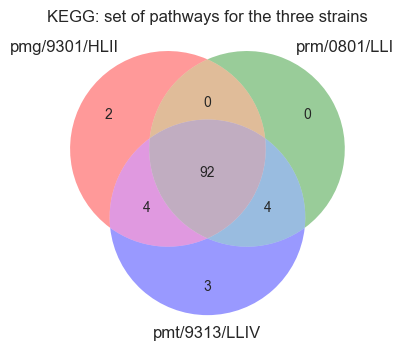

In [14]:
venn3_unweighted(subsets = (set(pmgTrim),set(prmTrim),set(pmtTrim)),set_labels = 
                 ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('KEGG: set of pathways for the three strains')
plt.savefig('Pro_pathways.png')

In [ ]:
#need to remember how to do this (5/2019)...start with one compound and find the reactions

In [23]:
kegg_get("C00719").read()

'ENTRY       C00719                      Compound\nNAME        Betaine;\n            Trimethylaminoacetate;\n            Glycine betaine;\n            N,N,N-Trimethylglycine;\n            Trimethylammonioacetate\nFORMULA     C5H11NO2\nEXACT_MASS  117.079\nMOL_WEIGHT  117.1463\nREMARK      Same as: D07523\nREACTION    R02565 R02566 R02821 R07228 R07244 R08211 R08212 R10061 \n            R10062\nPATHWAY     map00260  Glycine, serine and threonine metabolism\n            map01100  Metabolic pathways\n            map02010  ABC transporters\nMODULE      M00555  Betaine biosynthesis, choline => betaine\nENZYME      1.1.3.17        1.2.1.8         1.21.4.4        2.1.1.5         \n            2.1.1.157       2.1.1.161       2.1.1.162\nBRITE       Anatomical Therapeutic Chemical (ATC) classification [BR:br08303]\n             A ALIMENTARY TRACT AND METABOLISM\n              A16 OTHER ALIMENTARY TRACT AND METABOLISM PRODUCTS\n               A16A OTHER ALIMENTARY TRACT AND METABOLISM PRODUCTS\n 

In [29]:
kegg_link("rn","C00719").read()

'cpd:C00719\trn:R02565\ncpd:C00719\trn:R02566\ncpd:C00719\trn:R02821\ncpd:C00719\trn:R07228\ncpd:C00719\trn:R07244\ncpd:C00719\trn:R08211\ncpd:C00719\trn:R08212\ncpd:C00719\trn:R10061\ncpd:C00719\trn:R10062\n'

In [33]:
#trim a pathway/compound list
def trimReactions(rnString):
    export_trimRn = []
    current_section = None
    for line in rnString.rstrip().split("\n"):
        #print(line)
        r = line.find('rn:')
        tp = line[r + 3 : r+9]
        export_trimRn.append(tp)
    return export_trimRn

In [34]:
test = kegg_link("rn","C00719").read()

In [59]:
pmtGenes = trimGenes(kegg_link("ko","pmt").read())

In [63]:
type(pmtGenes)

list

In [35]:
trimReactions(test)

['R02565',
 'R02566',
 'R02821',
 'R07228',
 'R07244',
 'R08211',
 'R08212',
 'R10061',
 'R10062']

In [36]:
#have list of reactions....go find the genes

In [75]:
trimGenes(kegg_link("ko","R07244").read())

['K13042']

In [79]:
"K13042" in pmtGenes

True

In [80]:
"K13042" in prmGenes

False

In [72]:
#now see if those genes are in any of the Pro strains

In [77]:
#pull the full set of compounds for each strain...
#have to loop through the genes because the KEGG / REST code will not do this 
#pull the full set of genes for each strain...
pmtGenes = trimGenes(kegg_link("ko","pmt").read())
pmgGenes = trimGenes(kegg_link("ko","pmg").read())
prmGenes = trimGenes(kegg_link("ko","prm").read())

In [ ]:
#these next cells are time consuming and are now (in 5/2019) timing out...

In [29]:
#setup the strings to match first
rnString = re.compile('(?:[rn:R])(\d+)$') #will return R00190
cpdString = re.compile('(?:[cpd:C])(\d+)$') #will return C00190

pmg_countCpd = []
pmg_countGene = []
pmg_countRxn = []
        
for gen in pmgGenes: #go through each gene...one at a time
    rnList = kegg_link('reaction',gen).read() #get the list of reactions for that gene
    #can have cases where there is a gene and no reaction (K02906 for example). This returns rnList = '\n'
    #since this is not actually empty...need a few way to filter those out
    test = '\n'
    if test != rnList:
        for line in rnList.rstrip().split('\n'):
            m = rnString.search(line) #get the reaction number
            pmg_countRxn.append(m.group(0))
            cpdList = kegg_link('cpd',m.group(0)).read() #now go get the compounds for that reaction
            del m #have to do this so I can pickle the whole thing later...
            #can have no compounds in a reaction (only glycans, begin with G, nothing I have matched)
            if len(cpdList) > 1: #will be true if cpdList includes compounds
                for line2 in cpdList.rstrip().split('\n'):
                    m2 = cpdString.search(line2).group(0)
                    pmg_countCpd.append(m2) 
                    pmg_countGene.append(gen)

In [30]:
pmt_countCpd = []
pmt_countGene = []
pmt_countRxn = []

for gen in pmtGenes: #go through each gene...one at a time
    rnList = kegg_link('reaction',gen).read() #get the list of reactions for that gene
    #can have cases where there is a gene and no reaction (K02906 for example). This returns rnList = '\n'
    #since this is not actually empty...need a few way to filter those out
    test = '\n'
    if test != rnList:
        for line in rnList.rstrip().split('\n'):
            m = rnString.search(line) #get the reaction number
            pmt_countRxn.append(m.group(0))
            cpdList = kegg_link('cpd',m.group(0)).read() #now go get the compounds for that reaction
            del m #have to do this so I can pickle the whole thing later...
            #can have no compounds in a reaction (only glycans, begin with G, nothing I have matched)
            if len(cpdList) > 1: #will be true if cpdList includes compounds
                for line2 in cpdList.rstrip().split('\n'):
                    m2 = cpdString.search(line2).group(0)
                    pmt_countCpd.append(m2) 
                    pmt_countGene.append(gen)

In [31]:
prm_countCpd = []
prm_countGene = []
prm_countRxn = []

for gen in prmGenes: #go through each gene...one at a time
    rnList = kegg_link('reaction',gen).read() #get the list of reactions for that gene
    #can have cases where there is a gene and no reaction (K02906 for example). This returns rnList = '\n'
    #since this is not actually empty...need a few way to filter those out
    test = '\n'
    if test != rnList:
        for line in rnList.rstrip().split('\n'):
            m = rnString.search(line) #get the reaction number
            prm_countRxn.append(m.group(0))
            cpdList = kegg_link('cpd',m.group(0)).read() #now go get the compounds for that reaction
            del m #have to do this so I can pickle the whole thing later...
            #can have no compounds in a reaction (only glycans, begin with G, nothing I have matched)
            if len(cpdList) > 1: #will be true if cpdList includes compounds
                for line2 in cpdList.rstrip().split('\n'):
                    m2 = cpdString.search(line2).group(0)
                    prm_countCpd.append(m2) 
                    prm_countGene.append(gen)

Consider the overlap in compounds among the three strains
---

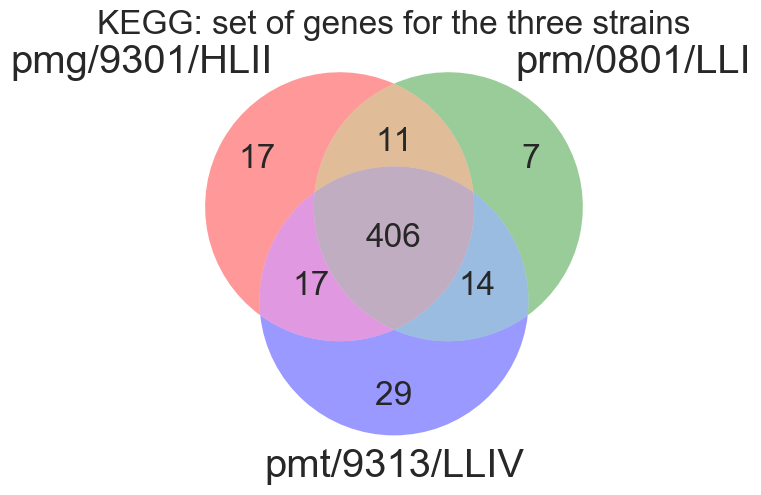

In [32]:
v = venn3_unweighted(subsets = (set(pmg_countGene),set(prm_countGene),set(pmt_countGene)),set_labels = 
                 ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('KEGG: set of genes for the three strains')
#plt.savefig('Pro_genes.png')

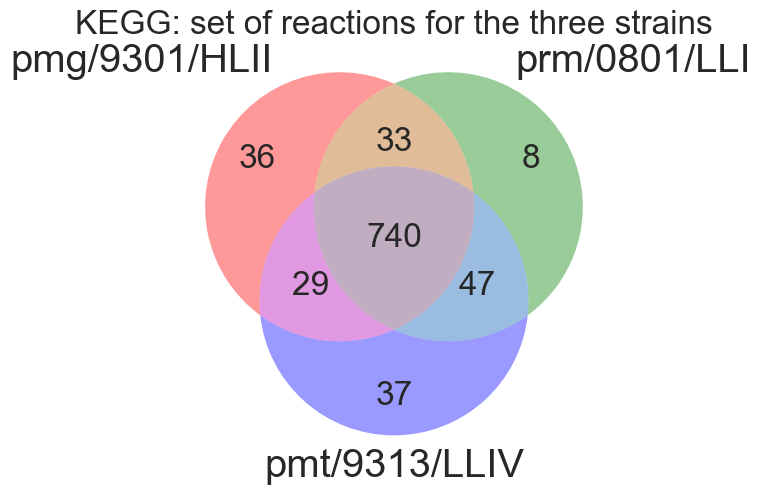

In [33]:
v = venn3_unweighted(subsets = (set(pmg_countRxn),set(prm_countRxn),set(pmt_countRxn)),set_labels = 
                 ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('KEGG: set of reactions for the three strains')
#plt.show() #don't do this...this creates a new figure
#plt.savefig('Pro_reactions.png')

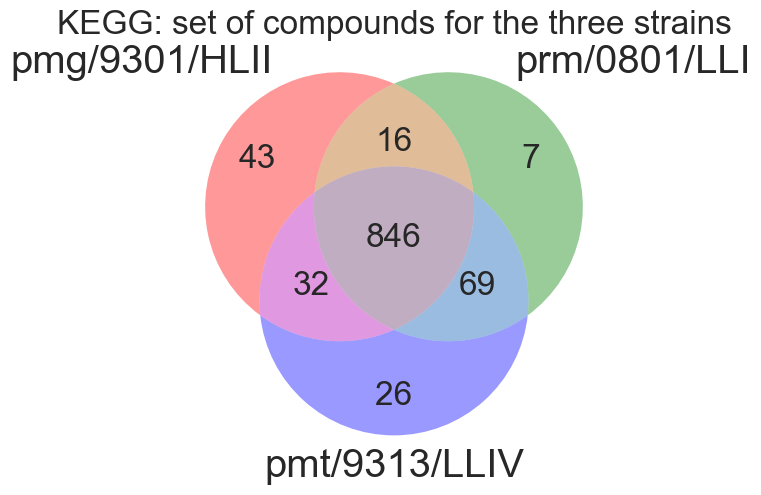

In [34]:
venn3_unweighted(subsets = (set(pmg_countCpd),set(prm_countCpd),set(pmt_countCpd)),set_labels = 
                 ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('KEGG: set of compounds for the three strains')
plt.savefig('Pro_cpds.png')

In [35]:
#what are the differences?
rxnString = set(prm_countRxn) - (set(pmg_countRxn)| set(pmt_countRxn))
#rxnString = set(pmg_countRxn) - (set(prm_countRxn)| set(pmt_countRxn))
#rxnString = set(pmt_countRxn) - (set(prm_countRxn)| set(pmg_countRxn))
#set(pmg_countGene) & set(prm_countGene)- set(pmt_countGene)
rxnString.pop()

'R00956'

In [36]:
kegg_get('R00956').read() #get information about a reaction

'ENTRY       R00956                      Reaction\nNAME        CTP:alpha-D-glucose-1-phosphate cytidylyltransferase\nDEFINITION  CTP + D-Glucose 1-phosphate <=> Diphosphate + CDP-glucose\nEQUATION    C00063 + C00103 <=> C00013 + C00501\nRCLASS      RC00002  C00103_C00501\nENZYME      2.7.7.33\nPATHWAY     rn00500  Starch and sucrose metabolism\n            rn00520  Amino sugar and nucleotide sugar metabolism\n            rn01100  Metabolic pathways\nORTHOLOGY   K00978  glucose-1-phosphate cytidylyltransferase [EC:2.7.7.33]\nDBLINKS     RHEA: 18216\n///\n'

In [37]:
# cpdString = set(pmg_countCpd) & set(prm_countCpd)& set(pmt_countCpd) #in all three.
#what are the compounds unique to each strain? Change the logic as needed.
cpdString = set(pmg_countCpd) - (set(prm_countCpd)| set(pmt_countCpd))
for item in cpdString:
    print(kegg_list(item).read())

cpd:C04712	(7R)-7-(5-Carboxy-5-oxopentanoyl)aminocephalosporinate

cpd:C01146	2-Hydroxy-3-oxopropanoate; Tartronate semialdehyde

cpd:C03440	cis-4-Hydroxy-D-proline

cpd:C03564	1-Pyrroline-2-carboxylate; 1-Pyrroline-2-carboxylic acid; Delta1-Pyrroline 2-carboxylate; 1-Pyrroline 2-carboxylate

cpd:C03771	5-Guanidino-2-oxopentanoate; 5-Guanidino-2-oxo-pentanoate; 2-Oxo-5-guanidinopentanoate; 2-Oxo-5-guanidino-pentanoate; 2-Oxoarginine

cpd:C00511	Acrylic acid; Propenoate; Acrylate; 2-Propenoic acid; Vinylformic acid

cpd:C05678	(2-Amino-1-hydroxyethyl)phosphonate; 1-Hydroxy-2-aminoethylphosphonate

cpd:C20267	4-Amino-5-aminomethyl-2-methylpyrimidine

cpd:C04282	1-Pyrroline-4-hydroxy-2-carboxylate

cpd:C01110	5-Amino-2-oxopentanoic acid; 5-Amino-2-oxopentanoate; 2-Oxo-5-amino-pentanoate; 2-Oxo-5-aminopentanoate; alpha-Keto-delta-aminopentanoate; 2-Oxo-5-aminovalerate

cpd:C01401	Alanine; 2-Aminopropionic acid; 2-Aminopropanoic acid

cpd:C04294	5-(2-Hydroxyethyl)-4-methylthiazole; 4-Methyl

In [38]:
# cpdString = set(pmg_countCpd) & set(prm_countCpd)& set(pmt_countCpd) #in all three.
#what are the compounds unique to each strain? Change the logic as needed.
cpdString = set(pmt_countCpd) - (set(prm_countCpd)| set(pmg_countCpd))
for item in cpdString:
    print(kegg_list(item).read())

cpd:C00534	Pyridoxamine; PM

cpd:C00575	3',5'-Cyclic AMP; Cyclic adenylic acid; Cyclic AMP; Adenosine 3',5'-phosphate; Adenosine 3',5'-cyclic phosphate; cAMP

cpd:C08276	3-(Methylthio)propanoate; 3-(Methylthio)propionic acid; 3-Methylthiopropionate

cpd:C00245	Taurine; 2-Aminoethanesulfonic acid; Aminoethylsulfonic acid

cpd:C01180	4-Methylthio-2-oxobutanoic acid; 4-Methylthio-2-oxobutanoate; 2-Keto-4-methylthiobutyric acid; 2-Oxo-4-methylthiobutanoate; 2-Oxo-4-methylthiobutanoic acid

cpd:C04582	S-Methyl-5-thio-D-ribulose 1-phosphate

cpd:C00942	3',5'-Cyclic GMP; Guanosine 3',5'-cyclic monophosphate; Guanosine 3',5'-cyclic phosphate; Cyclic GMP; cGMP

cpd:C00468	Estrone; 3-Hydroxy-1,3,5(10)-estratrien-17-one

cpd:C00721	Dextrin

cpd:C00519	Hypotaurine; 2-Aminoethanesulfinic acid

cpd:C00647	Pyridoxamine phosphate; Pyridoxamine 5-phosphate; Pyridoxamine 5'-phosphate

cpd:C01170	UDP-N-acetyl-D-mannosamine; UDP-N-acetyl-alpha-D-mannosamine

cpd:C06125	Sulfatide; Galactosylceramide sulfat

In [17]:
#Do the simplest count first, is a compound in anything from each strain?
#match this to the figure from KEGG for the IMBER poster

#slight hack
set_9301 = set()
st = 's9301'
for oneCpd in useCO:
    df2 = mtabPruned.loc[oneCpd].filter(regex = (st))
    r = df2[df2.gt(0)]
    if not r.empty:
        set_9301.add(oneCpd)
        
        
set_0801 = set()
st = 's0801'
for oneCpd in useCO:
    df2 = mtabPruned.loc[oneCpd].filter(regex = (st))
    r = df2[df2.gt(0)]
    if not r.empty:
        set_0801.add(oneCpd)
        
set_9313 = set()
st = 's9313'
for oneCpd in useCO:
    df2 = mtabPruned.loc[oneCpd].filter(regex = (st))
    r = df2[df2.gt(0)]
    if not r.empty:
        set_9313.add(oneCpd)


In [18]:
# venn3_unweighted(subsets = (set(pmg_countCpd),set(prm_countCpd),set(pmt_countCpd)),set_labels = 
#                  ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
# plt.title('KEGG: set of compounds for the three strains')
# plt.savefig('Pro_cpds.png')

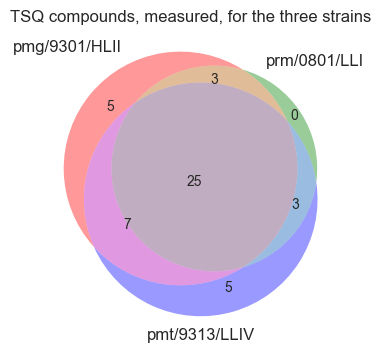

In [19]:
venn3([set_9301,set_0801,set_9313],set_labels = ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('TSQ compounds, measured, for the three strains')
plt.savefig('Pro_TSQmeasured_cpds.png')

In [ ]:
#hack, but Liz doesn't like the Venn diagram and wants a list of compounds...export the compounds as 
#KEGG numbers. Because I don't feel up to it, I will manually make this into a list of metabolite names
#4/19/2019

In [56]:
#did this multiple times and opened up next.csv in Excel after each time
import csv

all3 = (set(set_9313) & set(set_0801)) -  set(set_9301)

keep = []
for item in all3:
    if item in useCO:
        keep.append(item)
        
csvfile = "next.csv"

#Assuming res is a flat list
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in keep:
        writer.writerow([val])  

In [39]:
#remember - this is the theoretical overlap based on KEGG
all3 = set(pmg_countCpd) & set(prm_countCpd)& set(pmt_countCpd)

keep = []
for item in all3:
    if item in useCO:
        keep.append(item)
        #print(kegg_list(item).read())

In [44]:
for item in cpd_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(cpd_inNstrains.loc[item,'s9301']):
        pass
    else:
        #is in the list for strain?
        if item in pmg_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C00719	Betaine; Trimethylaminoacetate; Glycine betaine; N,N,N-Trimethylglycine; Trimethylammonioacetate

cpd:C06767	Hemine; Hemin



In [45]:
for item in cpd_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(cpd_inNstrains.loc[item,'s9313']):
        pass
    else:
        #is in the list for strain?
        if item in pmt_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C01674	Chitobiose; Diacetylchitobiose; N,N'-Diacetylchitobiose

cpd:C06767	Hemine; Hemin

cpd:C00315	Spermidine; N-(3-Aminopropyl)-1,4-butane-diamine



In [48]:
for item in gI:
    if fi1.loc[item,'s0801']==1:
        print(kegg_list(item).read())

cpd:C00568	4-Aminobenzoate; ABEE; 4-Aminobenzoic acid; p-Aminobenzoate



In [49]:
for item in gI:
    if fi1.loc[item,'s9313']==1:
        print(kegg_list(item).read())

cpd:C01674	Chitobiose; Diacetylchitobiose; N,N'-Diacetylchitobiose

cpd:C00092	D-Glucose 6-phosphate; Glucose 6-phosphate; Robison ester

cpd:C00123	L-Leucine; 2-Amino-4-methylvaleric acid; (2S)-alpha-2-Amino-4-methylvaleric acid; (2S)-alpha-Leucine

cpd:C00864	Pantothenate; Pantothenic acid; (R)-Pantothenate

cpd:C00106	Uracil



In [56]:
for item in released_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(released_inNstrains.loc[item,'s0801']):
        pass
    else:
        #is in the list for strain?
        if item in prm_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C19675	(R)-2,3-Dihydroxypropane-1-sulfonate

cpd:C00328	L-Kynurenine; 3-Anthraniloyl-L-alanine

cpd:C00385	Xanthine



In [57]:
for item in released_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(released_inNstrains.loc[item,'s9301']):
        pass
    else:
        #is in the list for strain?
        if item in pmg_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C19675	(R)-2,3-Dihydroxypropane-1-sulfonate



In [58]:
for item in released_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(released_inNstrains.loc[item,'s9313']):
        pass
    else:
        #is in the list for strain?
        if item in pmt_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C00328	L-Kynurenine; 3-Anthraniloyl-L-alanine

cpd:C00385	Xanthine



In [59]:
oneCpd='C00954'
r = kegg_link('pathway',oneCpd).read()
m = trimMap(r)

for item in m:
    print(kegg_list(item).read())

path:map00380	Tryptophan metabolism

path:map01070	Biosynthesis of plant hormones

path:map01100	Metabolic pathways

path:map04075	Plant hormone signal transduction



In [93]:
import dill
# and to load the session again:
dill.load_session('globalsave.pkl')

In [94]:
# leave debris below here for now, notebook will stop at the 'raise' 
# command here that will keep me from running cells 
# of code that are not meant to be connected
raise

RuntimeError: No active exception to reraise